In [1]:
!pip install datasets
!pip install transformers
!pip install scikit-plot
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 69.8 MB/s eta 0:00

In [2]:
import pandas as pd
import numpy as np

import seaborn as sb
import scikitplot 
from matplotlib import pyplot as plotGraph
#import wandb

from sklearn.metrics import classification_report, accuracy_score

from datasets import load_metric, load_dataset, Features, ClassLabel, Array3D, Image
from transformers import default_data_collator, Trainer, TrainingArguments, ViTForImageClassification, ViTFeatureExtractor, EarlyStoppingCallback

In [3]:
#wandb.login()

In [4]:
#%env WANB_LOG_MODEL = true
#%env WANB_PROJECT = ferUniversal_finetuning_transformer

## Preprocessing

In [5]:
ferUniverse_data = load_dataset('FER-Universe/DiffusionFER', split="train")

Extracting data files:   0%|          | 0/15 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/FER-Universe___imagefolder/FER-Universe--DiffusionFER-584755ddb54e5e9f/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


In [6]:
ferUniverse_data

Dataset({
    features: ['image', 'label'],
    num_rows: 2581
})

## Preprocessing

<Axes: ylabel='count'>

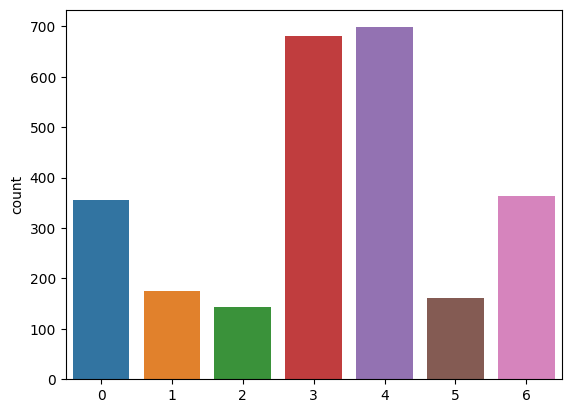

In [7]:
sb.countplot(x=ferUniverse_data["label"])

In [8]:
ferUniverse_df = pd.DataFrame()

ferUniverse_df["image"] = ferUniverse_data["image"]
ferUniverse_df["emotion"] = ferUniverse_data["label"]
ferUniverse_df

,image,emotion
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,0
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,0
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,0
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,0
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,0
...,...,...
2576,<PIL.PngImagePlugin.PngImageFile image mode=RG...,6
2577,<PIL.PngImagePlugin.PngImageFile image mode=RG...,6
2578,<PIL.PngImagePlugin.PngImageFile image mode=RG...,6
2579,<PIL.PngImagePlugin.PngImageFile image mode=RG...,6


In [9]:
emotion_labels = {
    0: "anger",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "neutral",
    5: "sad",
    6: "surprise"
}

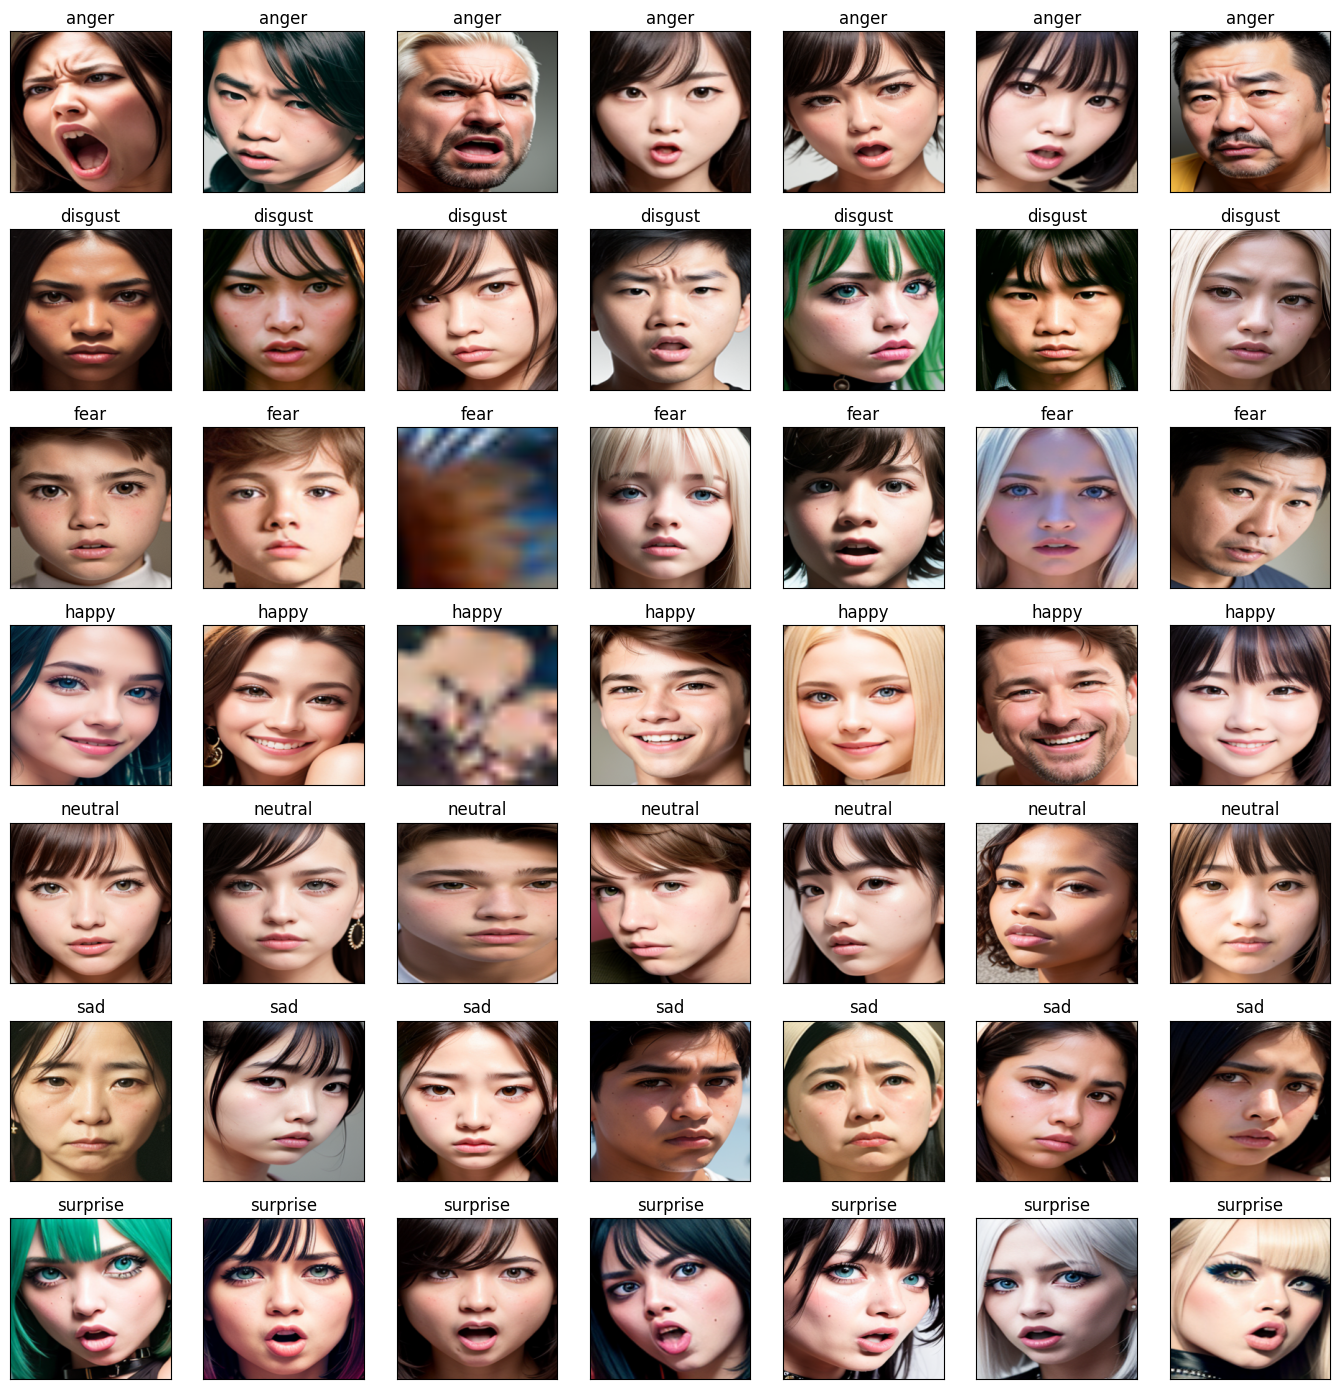

In [10]:
figure = plotGraph.figure(1,(14,14))

k = 0

for label in sorted(ferUniverse_df.emotion.unique()):
  for i in range(7):
    pixels = ferUniverse_df[ferUniverse_df.emotion == label].image.iloc[i]

    k = k +1

    ax = plotGraph.subplot(7,7,k)
    ax.imshow(pixels, cmap = "gray")
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_title(emotion_labels[label])
    plotGraph.tight_layout()

In [11]:
# split data in training and testing datasets
data_split = ferUniverse_data.train_test_split(test_size = 0.2, seed = 42, stratify_by_column ="label")

In [12]:
train_data = data_split["train"]
test_data = data_split["test"]

In [13]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [14]:
def preprocess_images(data):
  images = data["image"]
  images = [np.array(image, dtype=np.uint8) for image in images]
  images = [np.moveaxis(image, source=-1, destination = 0) for image in images]
  inputs = feature_extractor(images = images)
  data["pixel_values"] = inputs["pixel_values"]
  
  return data

In [15]:
features = Features({
    "label": ClassLabel(names = ["anger","disgust","fear","happy","neutral","sad","surprise"]),
    "image": Image(decode = True, id = None),
    "pixel_values": Array3D(dtype="float32", shape=(3,224,224)),  
})

In [16]:
preprocessed_train_data = train_data.map(preprocess_images, batched = True, features = features)
preprocessed_test_data = test_data.map(preprocess_images, batched = True, features = features)

Map:   0%|          | 0/2064 [00:00<?, ? examples/s]

Map:   0%|          | 0/517 [00:00<?, ? examples/s]

In [17]:
preprocessed_train_data

Dataset({
    features: ['label', 'image', 'pixel_values'],
    num_rows: 2064
})

In [18]:
len(preprocessed_train_data)

2064

In [19]:
preprocessed_test_data

Dataset({
    features: ['label', 'image', 'pixel_values'],
    num_rows: 517
})

In [20]:
len(preprocessed_test_data)

517

## Model

In [21]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

## Train Model

In [22]:
# model.train()

In [23]:
def compute_metrics(preds):
  logits, labels = preds
  predictions = np.argmax(logits, axis =1)
  return metric.compute(predictions = predictions, references = labels)

In [24]:
data_collator = default_data_collator

In [25]:
metric_name = "accuracy"
metric = load_metric(metric_name)

<ipython-input-25-2f6534a45fa4>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric(metric_name)


In [26]:
early_stopping = EarlyStoppingCallback(
    early_stopping_patience = 1,
    early_stopping_threshold = 0.00005
)

In [27]:
args = TrainingArguments(
    output_dir = "/content/drive/MyDrive/17644_MoodDetectives/Transformers/FINAL/FERUNIVERSAL/checkpoints-fer-universe-folder",
    #report_to="wandb",
    #run_name = "ferUniversal_finetune_transformer_final",
    evaluation_strategy = "steps",
    save_strategy ="steps",
    logging_strategy = "steps",
    seed = 42,
    learning_rate = 2e-5,
    per_device_train_batch_size = 10,
    per_device_eval_batch_size = 4,
    num_train_epochs = 5,
    weight_decay = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = metric_name,
    logging_dir = "logs"
)

In [28]:
trainer = Trainer(
    model,
    args,
    train_dataset = preprocessed_train_data,
    eval_dataset = preprocessed_test_data,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
    callbacks = [early_stopping]
)

In [29]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy
500,0.782200,0.498372,0.854932
1000,0.065200,0.467337,0.880077


TrainOutput(global_step=1035, training_loss=0.40985225338290854, metrics={'train_runtime': 2563.7328, 'train_samples_per_second': 4.025, 'train_steps_per_second': 0.404, 'total_flos': 8.068706110970266e+17, 'train_loss': 0.40985225338290854, 'epoch': 5.0})

In [30]:
#wandb.finish()

## Evaluate Model

In [31]:
outputs = trainer.predict(preprocessed_test_data)
class_predictions = outputs.predictions.argmax(1)
type(class_predictions)


numpy.ndarray

In [32]:
# get predictions
accuracy_score(preprocessed_test_data["label"], class_predictions)

0.8800773694390716

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

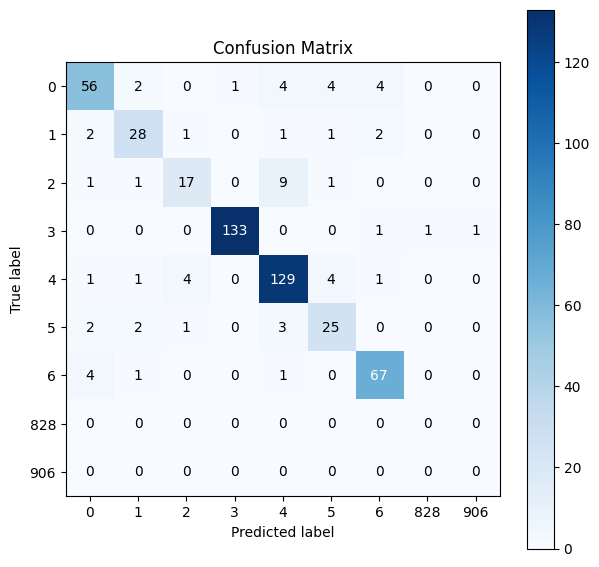

In [33]:
# confusion matrix

scikitplot.metrics.plot_confusion_matrix(
    preprocessed_test_data["label"],
    class_predictions,
    figsize = (7,7)
)

In [34]:
print(
    "Total Wrong Predictions:",
    np.sum(
        preprocessed_test_data["label"] != class_predictions
    )
)


print(
    classification_report(
        preprocessed_test_data["label"], class_predictions
    )
)

Total Wrong Predictions: 62
              precision    recall  f1-score   support

           0       0.85      0.79      0.82        71
           1       0.80      0.80      0.80        35
           2       0.74      0.59      0.65        29
           3       0.99      0.98      0.99       136
           4       0.88      0.92      0.90       140
           5       0.71      0.76      0.74        33
           6       0.89      0.92      0.91        73
         828       0.00      0.00      0.00         0
         906       0.00      0.00      0.00         0

    accuracy                           0.88       517
   macro avg       0.65      0.64      0.64       517
weighted avg       0.88      0.88      0.88       517



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
trainer.save_model("/content/drive/MyDrive/17644_MoodDetectives/Transformers/FINAL/FERUNIVERSAL/final-model-fer-universe-folder")